Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz

from timeit import default_timer as timer
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix

from sklearn.tree import export_graphviz
from holoviews.ipython import display

Train data (longer)

In [2]:
path = "../12CPU_30RAM/43200s/allGroup/merged.csv"
df = pd.read_csv(path).dropna(inplace=False)

df = df.iloc[:,1:]

#single merge file (not grouped)
#df = df.iloc[:,2:]

#methods.csv
if "methods" in path:
    endpoint_map = {
        'do-register': 0,
        'add-sell-offer': 1,
        'add-buy-offer': 2,
        'get-stock-data': 3,
        'add-company': 4,
        'get-stock-users-and-companies': 5

    }
    # zastosowanie mapowania na kolumnę endpointUrl
    df['endpointUrl'] = df['endpointUrl'].replace(endpoint_map)


if 'replicaId' in df.columns:
    df['replicaId'] = pd.factorize(df['replicaId'])[0]

#zaokrąglij dane procentowe zużycia do dwóch miejsc po przecinku
cols_to_round = [col for col in df.columns if col.endswith('memoryUsage') or col.endswith('cpuUsage')]
if cols_to_round:
    # round the columns to two decimal places
    df[cols_to_round] = df[cols_to_round].round(2)

df.info()
print(df.head())

#stock,trading

#methods: timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,replicaId
#stock : timestamp,cpuUsage,memoryUsage,replicaId
#trading: timestamp,applicationTime,databaseTime,numberOfSellOffers,numberOfBuyOffers,replicaId
#traffic: timestamp,cpuUsage,memoryUsage
#merged: ,timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,st_cpuUsage,st_memoryUsage,trad_applicationTime,trad_databaseTime,trad_numberOfSellOffers,trad_numberOfBuyOffers,traf_cpuUsage,traf_memoryUsage

#df.loc[:,[3, 5]]

#X = df.drop(["endpointUrl"], axis=1);
#X = df.filter(["queueSizeBack", "trad_numberOfBuyOffers", "trad_numberOfSellOffers"])
#X_train = df.drop(["endpointUrl", "apiTime", "applicationTime", "databaseTime", "trad_applicationTime"], axis=1)
X_train = df.drop(["endpointUrl"], axis=1)
Y_train = df["endpointUrl"];



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44937168 entries, 0 to 44937167
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   apiTime                  int64  
 1   applicationTime          int64  
 2   databaseTime             int64  
 3   endpointUrl              int64  
 4   queueSizeForward         int64  
 5   queueSizeBack            int64  
 6   st_cpuUsage              float64
 7   st_memoryUsage           float64
 8   trad_applicationTime     int64  
 9   trad_databaseTime        int64  
 10  trad_numberOfSellOffers  int64  
 11  trad_numberOfBuyOffers   int64  
 12  traf_cpuUsage            float64
 13  traf_memoryUsage         float64
dtypes: float64(4), int64(10)
memory usage: 4.7 GB
   apiTime  applicationTime  databaseTime  endpointUrl  queueSizeForward  \
0      485              244           102            0                 0   
1      506              262           120            0                 0  

Test data (shorter)

In [8]:
path = "../12CPU_30RAM/3600s/allGroup/merged.csv"
df = pd.read_csv(path).dropna(inplace=False)

df = df.iloc[:,1:]

#single merge file (not grouped)
#df = df.iloc[:,2:]

#methods.csv
if "methods" in path:
    endpoint_map = {
        'do-register': 0,
        'add-sell-offer': 1,
        'add-buy-offer': 2,
        'get-stock-data': 3,
        'add-company': 4,
        'get-stock-users-and-companies': 5

    }
    # zastosowanie mapowania na kolumnę endpointUrl
    df['endpointUrl'] = df['endpointUrl'].replace(endpoint_map)


if 'replicaId' in df.columns:
    df['replicaId'] = pd.factorize(df['replicaId'])[0]

#zaokrąglij dane procentowe zużycia do dwóch miejsc po przecinku
cols_to_round = [col for col in df.columns if col.endswith('memoryUsage') or col.endswith('cpuUsage')]
if cols_to_round:
    # round the columns to two decimal places
    df[cols_to_round] = df[cols_to_round].round(2)

df.info()
print(df.head())

#stock,trading

#methods: timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,replicaId
#stock : timestamp,cpuUsage,memoryUsage,replicaId
#trading: timestamp,applicationTime,databaseTime,numberOfSellOffers,numberOfBuyOffers,replicaId
#traffic: timestamp,cpuUsage,memoryUsage
#merged: ,timestamp,apiTime,applicationTime,databaseTime,endpointUrl,queueSizeForward,queueSizeBack,st_cpuUsage,st_memoryUsage,trad_applicationTime,trad_databaseTime,trad_numberOfSellOffers,trad_numberOfBuyOffers,traf_cpuUsage,traf_memoryUsage

#df.loc[:,[3, 5]]

#X = df.drop(["endpointUrl"], axis=1);
#X = df.filter(["queueSizeBack", "trad_numberOfBuyOffers", "trad_numberOfSellOffers"])
#X_test = df.drop(["endpointUrl", "apiTime", "applicationTime", "databaseTime", "trad_applicationTime"], axis=1)
X_test = df.drop(["endpointUrl"], axis=1)
Y_test = df["endpointUrl"];


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589190 entries, 0 to 8589189
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   apiTime                  int64  
 1   applicationTime          int64  
 2   databaseTime             int64  
 3   endpointUrl              int64  
 4   queueSizeForward         int64  
 5   queueSizeBack            int64  
 6   st_cpuUsage              float64
 7   st_memoryUsage           float64
 8   trad_applicationTime     int64  
 9   trad_databaseTime        int64  
 10  trad_numberOfSellOffers  int64  
 11  trad_numberOfBuyOffers   int64  
 12  traf_cpuUsage            float64
 13  traf_memoryUsage         float64
dtypes: float64(4), int64(10)
memory usage: 917.4 MB
   apiTime  applicationTime  databaseTime  endpointUrl  queueSizeForward  \
0      409              229            87            0                 0   
1      413              226            88            0                 0  

 Definition of model

In [4]:
#split test - use for only one csv
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=44)
start = timer()

model = RandomForestClassifier(
            #default: 100, None, gini
            n_estimators=100,
            max_depth=None,
            criterion="gini"
)
model.fit(X_train, Y_train)

end = timer()
print(timedelta(seconds=end-start))

2:19:42.925414


In [9]:
predictions = model.predict(X_test)
print(predictions)

[5 5 3 ... 5 1 2]


In [10]:
print(Y_test)

0          0
1          0
2          0
3          0
4          0
          ..
8589185    2
8589186    5
8589187    5
8589188    2
8589189    2
Name: endpointUrl, Length: 8589190, dtype: int64


Calculating accuracy of prediction

In [11]:
model_RMSE = np.sqrt(mean_squared_error(Y_test, predictions))
print("RMSE: ", round(model_RMSE, 4))
print("Accuracy:", round(accuracy_score(Y_test, predictions), 4))

RMSE:  0.3738
Accuracy: 0.8767


RandForest graph draw (first n trees)

Drzewo nr # 1 / 100


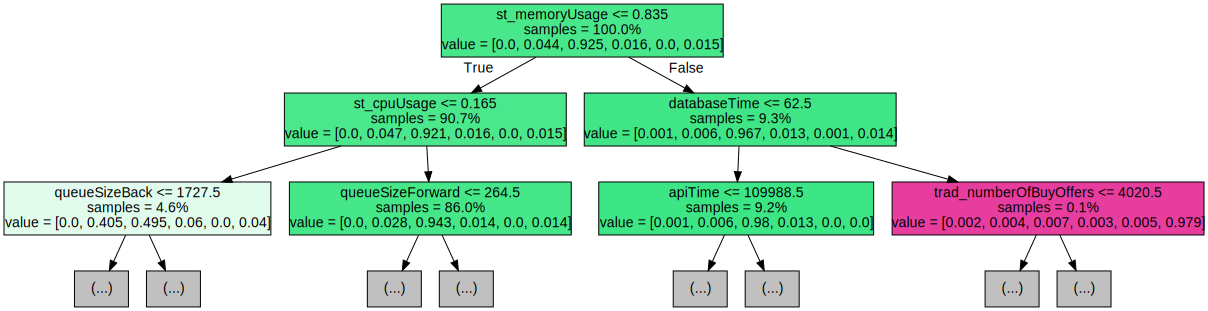

Drzewo nr # 2 / 100


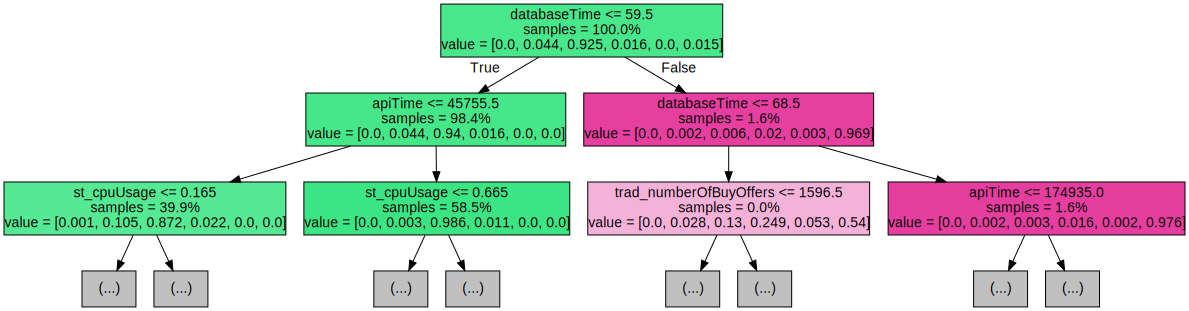

Drzewo nr # 3 / 100


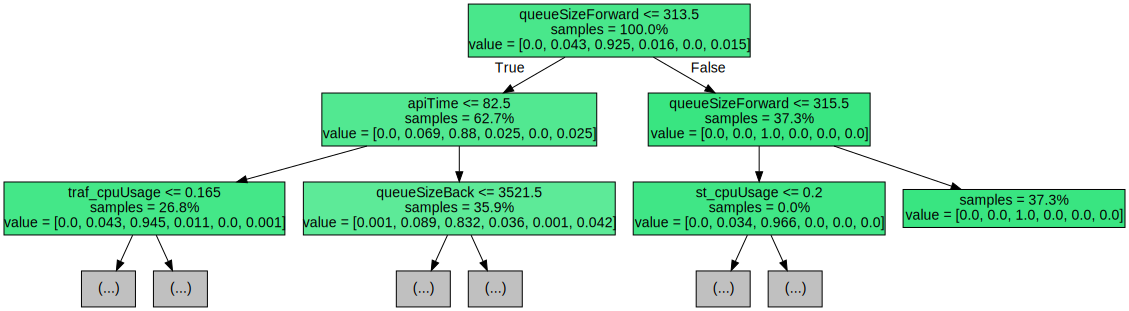

In [10]:
for i in range(3):
    tree = model.estimators_[i]
    tree_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(tree_data)
    print("Drzewo nr #", i+1, "/", model.n_estimators)
    display(graph)

Confusion matrix of predictions

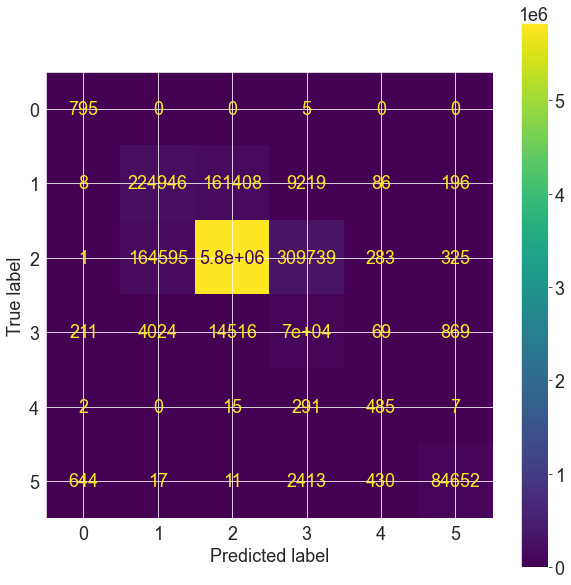

In [12]:

cm = confusion_matrix(Y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

plt.rc('font', size=18)
plt.show()